This notebook is for analysing the `NEXUS (.nxs)` HDF5 metadata file produced from a slow acquisition *(< 2 Hz)* Diamond experiment, which accompanies the set of diffraction pattern images. This `NEXUS` metadata file captures a large amound of information about the beamlines setup, as well as information related to each diffraction pattern images, such as the **time stamp**, along with additional information such as analogue outputs from the thermomechanical test rig for **position**, **load** and **temperature**. 

This notebook can be used to access this experimental data and to save it as a text file.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nexusformat.nexus import *

%matplotlib inline

# NXS Metadata and Analogue Output Analysis

Load in the file paths to the `NEXUS` metadata file.

In [2]:
experiment_number = "111670"
experiment_name = "033_Ti64_TIFUN-T6_Heat_1200C_1Cs-1"

input_file = f"../../SXRD_raw_data/diamond_2022/rawdata/{experiment_number}.nxs"
output_folder = f"../../SXRD_analysis/diamond_2022/{experiment_name}/analogue-output"

Show the structure of the `NEXUS` metadata file.

In [3]:
metadata = nxload(input_file)
print("The class names contained within the NEXUS metadata, along with @target which shows how to access the data...", end = "\n\n")
print(metadata.tree)

The class names contained within the NEXUS metadata, along with @target which shows how to access the data...

root:NXroot
  entry1:NXentry
    before_scan:NXcollection
      cam1:NXcollection
        cam1_roll = 0.0299969
        cam1_x = 291.83
        cam1_z = -92.95984375
      dcm1_cap_1:NXcollection
        dcm1_cap_1 = 25.92
      dcm1_cap_2:NXcollection
        dcm1_cap_2 = 25.879
      f1 = 'clear'
        @local_name = 'f1.f1'
      f2 = 'clear'
        @local_name = 'f2.f2'
      mc1_bragg:NXcollection
        mc1_bragg = -1232.76297678678
      mc2:NXcollection
        mc2_bragg = -1250.79466546391
        mc2_z = 1133.5882507452
      mc2_bragg:NXcollection
        mc2_bragg = -1250.79466546391
      s1:NXcollection
        s1_bottom = -1.2491
        s1_in = -1.99945
        s1_out = 2.0004
        s1_t1 = 22.0
        s1_t2 = 21.5
        s1_top = 1.2507
        s1_xc = 0.0005
        s1_xs = 3.999875
        s1_yc = 0.0008
        s1_ys = 2.4998
      s2:NXcollection
  

Write the time, position, load and temperature values from the `NEXUS` metadata to a new dictionary.

In [4]:
time = metadata.entry1.instrument.actualTime.actualTime

image_number = metadata.entry1.instrument.ix.ix
position = metadata.entry1.instrument.adc01_06.adc01_06
load = metadata.entry1.instrument.adc01_08.adc01_08
temperature = metadata.entry1.instrument.adc01_07.adc01_07

position_conversion = 0.25 # mm/V
load_conversion = 250 # N/V
temperature_conversion = 150 # degC/V

analogue_data = {
                 "image number": image_number,
                 "time": time,
                 "position": position*position_conversion,
                 "load": load*load_conversion,
                 "temperature": temperature*temperature_conversion
                }

analogue_length = len(time)

print("The time, position, load and temperature have been written to a new dictionary.", end = "\n\n")
print("There are ", analogue_length, " data points contained within the NEXUS file.", end = "\n\n")

The time, position, load and temperature have been written to a new dictionary.

There are  3352  data points contained within the NEXUS file.



# Calculate the Acquisition Frequency

The new Pilatus detector at Diamond has an issue whereby the data acquisition rate of the detector is not quite what has been set during collection. We can calculate the actual acquisition frequency of the detector using the command below.

In [5]:
time = metadata.entry1.instrument.actualTime.actualTime

In [6]:
time_array = []

for i in range(len(time)):
    time_array.append(time[i])
    
acquisition_frequency_SXRD = 1 / np.average(np.diff(time_array))
print("The acquisition frequency of the SXRD diffraction patterns is: ", acquisition_frequency_SXRD, " Hz.")

The acquisition frequency of the SXRD diffraction patterns is:  1.3330522161995635  Hz.


# Save the Analogue Output to a Text File

In [ ]:
output_path = output_folder + "/analogue_data.txt"

CHECK_FOLDER = os.path.isdir(output_folder)

if not CHECK_FOLDER:
    os.makedirs(output_folder)
    print("Created folder : ", output_folder)      

with open(output_path, 'w') as output_file:
    # write metadata for the top of the file
    output_file.write(f"Image Number \t Time (s) \t Position (mm) \t Load (N) \t ETMT Temperature (C)\n")
    
    for i in range(len(analogue_data["image number"]):
        image_number_value = int(analogue_data["image number"][i])
        time_value = float(analogue_data["time"][i])
        position_value = float(analogue_data["position"][i])
        load_value = float(analogue_data["load"][i])
        temperature_value = float(analogue_data["temperature"][i])
        output_file.write(f"{image_number_value} \t {time_value} \t {position_value} \t {load_value} \t {temperature_value} \n")

print(f"Written file to : {output_file}.")

# Calculate the Eurotherm Temperature from the Excel spreadsheet

Load in the columns from the Electro Thermal Mechanical Tester (ETMT) data file. The ETMT data file is typically called something like `Test1.steps.tracking.csv`. The columns recording the ETMT data in the file may be organised and labelled differently depending on which ETMT you have used and how the output was setup in the method.

*Note, in python the first column is zero.*

In [7]:
# use this cell for the data inputs for the Diamond data collected in 2022

# give the dimensions of the sample in millimetres
length = 2 # note, this is the distance between resistivity wires, usually 2 mm
thickness = 2
width = 4

# identify the columns to upload from the file
use_columns = (0,8,11,16,14,17,15,19)

column = {  "time": 0, # time in Seconds
            "position" : 1, # position / displacement in Millimetres
            "load" : 2, # load in Newtons
            "current" : 3, # current in Amps
            "temperature" : 4, # temperature in Celsius recoded at ETMT
            "voltage" : 5, # voltage in Volts
            "temperature_eurotherm" : 6, # temperature in Celsius recoded at Eurotherm
            "frame" : 7 # frame signal
            }

# provide the relative filepath to the ETMT data file
input_filepath = "../../SXRD_raw_data/diamond_2022/rawdata_ETMT/033_Ti64_TIFUN-T6_Heat_1200C_1Cs-1/Test1/Test1.steps.tracking.csv"

This next cell uses the inputs defined above to load the data into an array, which we can then use to analyse and plot our ETMT data.

In [8]:
ETMT_data_array = np.loadtxt(input_filepath, skiprows=1, delimiter=',', usecols = use_columns)
ETMT_data_array = ETMT_data_array.T

The acquisition frequency of the ETMT data can be calculated below.

In [9]:
acquisition_frequency_ETMT = 1 / np.average(np.diff(ETMT_data_array[[column["time"]]]))
print("The acquisition frequency of the ETMT data collection is: ", acquisition_frequency_ETMT, " Hz.")

The acquisition frequency of the ETMT data collection is:  100.00270365263472  Hz.


We can plot the position, load and temperature behaviour from the ETMT data and from the SXRD image data.

This is useful to compare with a calculation of the maximum position, load and temperature from the ETMT data and from the SXRD image data, to check we have determined the correct values.

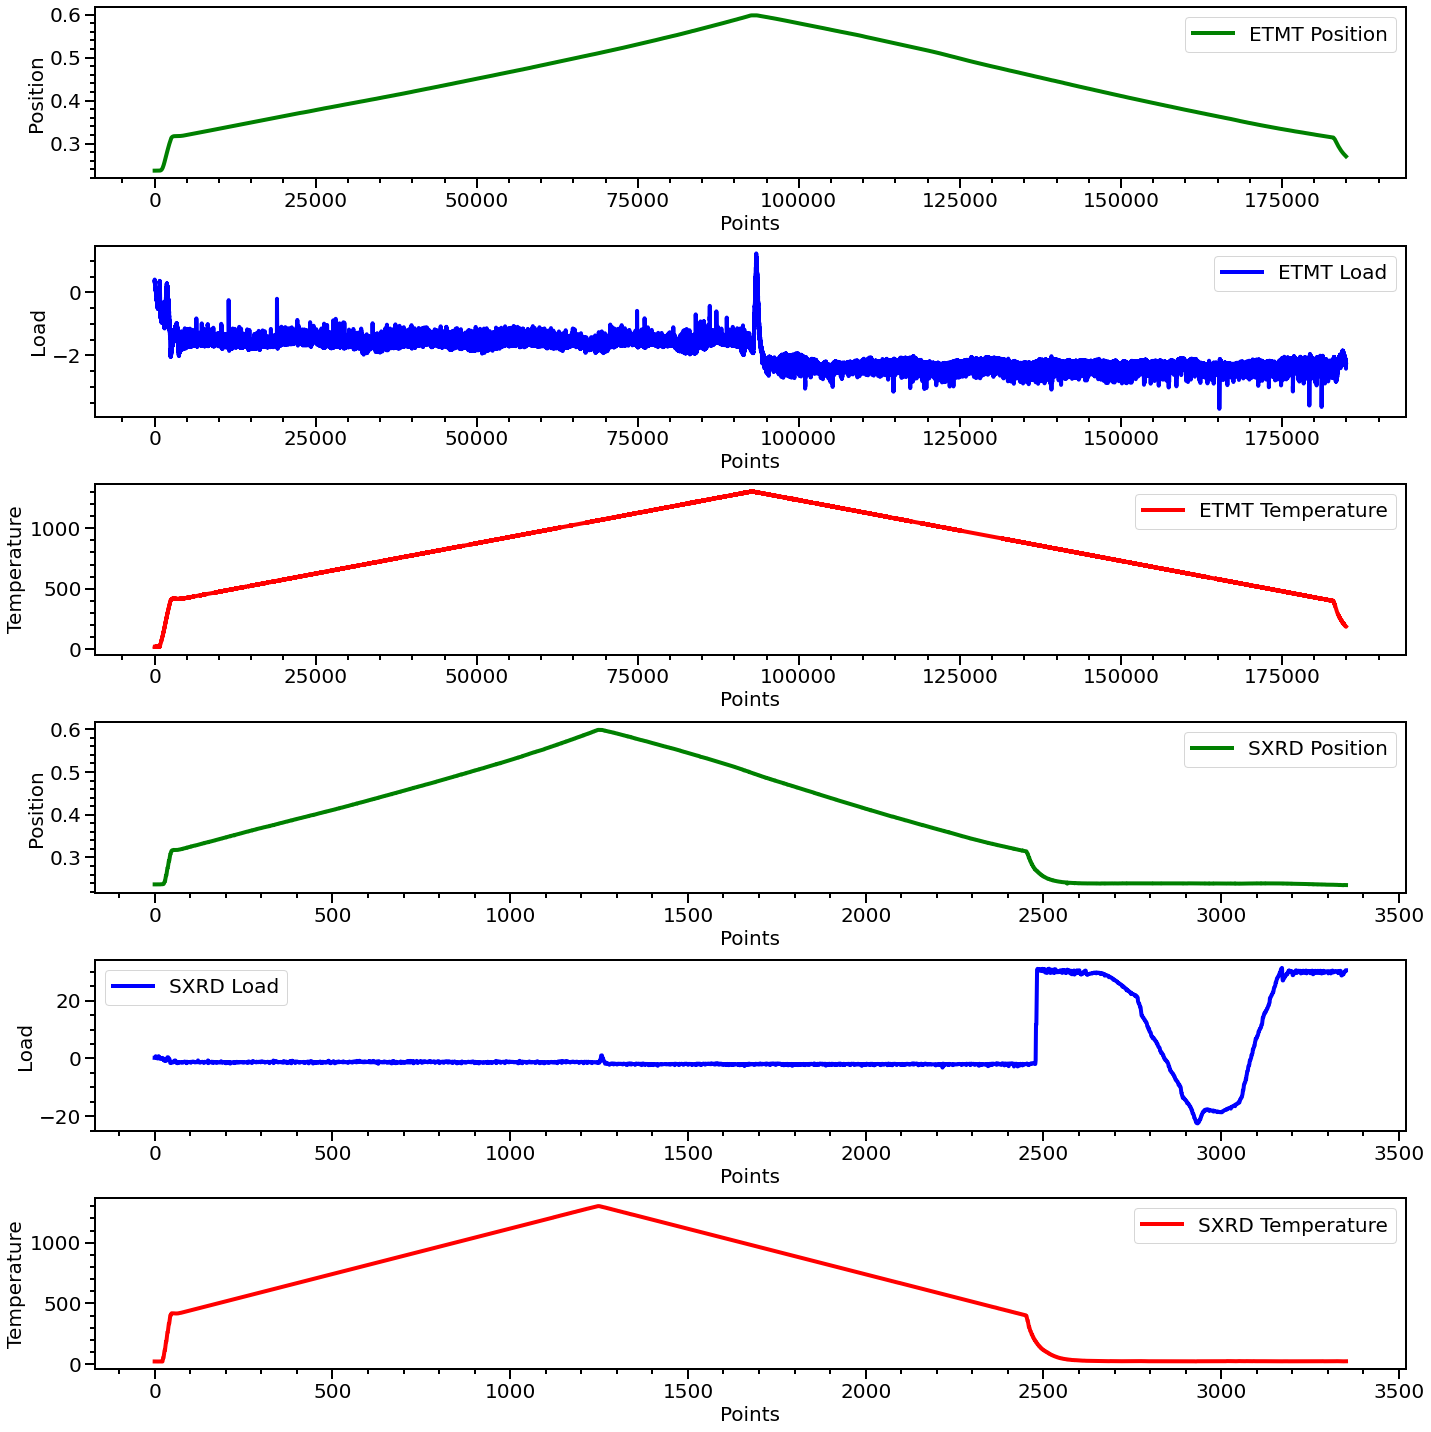

In [10]:
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.rc('legend', fontsize = 20)
plt.rc('axes', linewidth = 2)
plt.rc('xtick.major', width = 2, size = 10)
plt.rc('xtick.minor', width = 2, size = 5)
plt.rc('ytick.major', width = 2, size = 10)
plt.rc('ytick.minor', width = 2, size = 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, figsize = (20, 20))

ax1.minorticks_on()
ax1.plot(ETMT_data_array[column["position"]], color = "green", linewidth = 4, label = "ETMT Position")
ax1.set_xlabel(r"Points", fontsize = 20)
ax1.set_ylabel(r"Position", fontsize = 20)
ax1.legend()

ax2.minorticks_on()
ax2.plot(ETMT_data_array[column["load"]], color = "blue", linewidth = 4, label = "ETMT Load")
ax2.set_xlabel(r"Points", fontsize = 20)
ax2.set_ylabel(r"Load", fontsize = 20)
ax2.legend()

ax3.minorticks_on()
ax3.plot(ETMT_data_array[column["temperature"]], color = "red", linewidth = 4, label = "ETMT Temperature")
ax3.set_xlabel(r"Points", fontsize = 20)
ax3.set_ylabel(r"Temperature", fontsize = 20)
ax3.legend()

ax4.minorticks_on()
ax4.plot(list(analogue_data["position"]), color = "green", linewidth = 4, label = "SXRD Position")
ax4.set_xlabel(r"Points", fontsize = 20)
ax4.set_ylabel(r"Position", fontsize = 20)
ax4.legend()

ax5.minorticks_on()
ax5.plot(list(analogue_data["load"]), color = "blue", linewidth = 4, label = "SXRD Load")
ax5.set_xlabel(r"Points", fontsize = 20)
ax5.set_ylabel(r"Load", fontsize = 20)
ax5.legend()

ax6.minorticks_on()
ax6.plot(list(analogue_data["temperature"]), color = "red", linewidth = 4, label = "SXRD Temperature")
ax6.set_xlabel(r"Points", fontsize = 20)
ax6.set_ylabel(r"Temperature", fontsize = 20)
ax6.legend()

fig.tight_layout()

The maximum position, load and temperature from the ETMT data and from the SXRD image data is calculated below.

In [11]:
max_pos_value_ETMT = max(ETMT_data_array[column["position"]])
max_pos_element_ETMT = (ETMT_data_array[column["position"]]).argmax()
print("The maximum position value on the ETMT has been found to be: ", max_pos_value_ETMT, ", which is element ", max_pos_element_ETMT, "in the array.", end = "\n\n")

max_load_value_ETMT = max(ETMT_data_array[column["load"]])
max_load_element_ETMT = (ETMT_data_array[column["load"]]).argmax()
print("The maximum load value on the ETMT has been found to be: ", max_load_value_ETMT, ", which is element ", max_load_element_ETMT, "in the array.", end = "\n\n")

max_temp_value_ETMT = max(ETMT_data_array[column["temperature"]])
max_temp_element_ETMT = (ETMT_data_array[column["temperature"]]).argmax()
print("The maximum temperature value on the ETMT has been found to be: ", max_temp_value_ETMT, ", which is element ", max_temp_element_ETMT, "in the array.", end = "\n\n")

max_pos_value_SXRD = max(analogue_data["position"])
max_pos_element_SXRD = (analogue_data["position"]).argmax()
print("The maximum position value from the SXRD image data has been found to be: ", max_pos_value_SXRD, ", which is element ", max_pos_element_SXRD, "in the array.", end = "\n\n")

max_load_value_SXRD = max(analogue_data["load"][0:1500])
max_load_element_SXRD = (analogue_data["load"][0:1500]).argmax()
print("The maximum load value from the SXRD image data has been found to be: ", max_load_value_SXRD, ", which is element ", max_load_element_SXRD, "in the array.", end = "\n\n")

max_temp_value_SXRD = max(analogue_data["temperature"])
max_temp_element_SXRD = (analogue_data["temperature"]).argmax()
print("The maximum temperature value from the SXRD image data has been found to be: ", max_temp_value_SXRD, ", which is element ", max_temp_element_SXRD, "in the array.", end = "\n\n")

The maximum position value on the ETMT has been found to be:  0.598342111334205 , which is element  92919 in the array.

The maximum load value on the ETMT has been found to be:  1.23775098472834 , which is element  93392 in the array.

The maximum temperature value on the ETMT has been found to be:  1300.72233360261 , which is element  92700 in the array.

The maximum position value from the SXRD image data has been found to be:  0.59875 , which is element  1251 in the array.

The maximum load value from the SXRD image data has been found to be:  1.0655000000000001 , which is element  1258 in the array.

The maximum temperature value from the SXRD image data has been found to be:  1301.25 , which is element  1246 in the array.



Using the maximum position, load and temperature from the ETMT and SXRD data, we can synchronise the data by calculating a start element and using a ratio of the acquisition frequencies for the ETMT and SXRD datasets.

In [12]:
ratio_of_elements = acquisition_frequency_ETMT / acquisition_frequency_SXRD
print("The ratio of elements is: ", ratio_of_elements, end = "\n\n")

start_pos_element_ETMT = max_pos_element_ETMT - (max_pos_element_SXRD * ratio_of_elements)
print("The start element using position has been found to be: ", start_pos_element_ETMT, end = "\n\n")

start_load_element_ETMT = max_load_element_ETMT - (max_load_element_SXRD * ratio_of_elements)
print("The start element using load has been found to be: ", start_load_element_ETMT, end = "\n\n")

start_temp_element_ETMT = max_temp_element_ETMT - (max_temp_element_SXRD * ratio_of_elements)
print("The start element using temperature has been found to be: ", start_temp_element_ETMT, end = "\n\n")

start_element = (start_pos_element_ETMT + start_load_element_ETMT + start_temp_element_ETMT) / 3
print("The average start element has been found to be: ", start_element, end = "\n\n")

The ratio of elements is:  75.017844340513

The start element using position has been found to be:  -928.32326998176

The start element using load has been found to be:  -980.4481803653471

The start element using temperature has been found to be:  -772.2340482791915

The average start element has been found to be:  -893.6684995420995



We can then calculate the Eurotherm temperature below.

In [13]:
temperature_eurotherm = []

for i in range(len(analogue_data["image number"])):
    
    element_number = int(start_element + (i * ratio_of_elements))
    max_element_number = len(ETMT_data_array[column["temperature_eurotherm"]])
    
    if element_number <= 0:
        temperature_eurotherm.append(ETMT_data_array[column["temperature_eurotherm"]][0])
    elif  element_number > 0 and element_number < max_element_number:
        temperature_eurotherm.append(ETMT_data_array[column["temperature_eurotherm"]][element_number])
    elif element_number > max_element_number:
        temperature_eurotherm.append(ETMT_data_array[column["temperature_eurotherm"]][max_element_number - 1])

# Save the Analogue Output with the Eurotherm Temperature to a Text File

In [14]:
output_path = output_folder + "/analogue_data.txt"

CHECK_FOLDER = os.path.isdir(output_folder)

if not CHECK_FOLDER:
    os.makedirs(output_folder)
    print("Created folder : ", output_folder)

with open(output_path, 'w') as output_file:
    # write metadata for the top of the file
    output_file.write(f"Image Number \t Time (s) \t Position (mm) \t Load (N) \t ETMT Temperature (C) \t Eurotherm Temperature (C) \n")
    
    for i in range(len(analogue_data["image number"])):
        image_number_value = int(analogue_data["image number"][i])
        time_value = float(analogue_data["time"][i])
        position_value = float(analogue_data["position"][i])
        load_value = float(analogue_data["load"][i])
        temperature_value = float(analogue_data["temperature"][i])
        temperature_eurotherm_value = temperature_eurotherm[i]
        output_file.write(f"{image_number_value} \t {time_value} \t {position_value} \t {load_value} \t {temperature_value} \t {temperature_eurotherm_value} \n")

print(f"Written file to : {output_file}.")

Written file to : <_io.TextIOWrapper name='../../SXRD_analysis/diamond_2022/033_Ti64_TIFUN-T6_Heat_1200C_1Cs-1/analogue-output/analogue_data.txt' mode='w' encoding='UTF-8'>.


# Plot the Time and Analogue Output Analysis [TODO]